# Differential Expression Pipeline

This notebook covers differential expression analysis of the ADTBI dataset using the PyDeseq2 python package. 

The package documentaton can be found here:
[Pydeseq2 Docs](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#id5)

Differential expression analysis in RNA sequencing (RNA-seq) is a crucial step in understanding how gene expression levels vary between different experimental conditions, tissues, or sample groups. The primary purpose of this analysis is to identify genes that are significantly upregulated or downregulated under for patients that have dementia vs those that do not. This process provides insight into the biological processes and molecular mechanisms associated with those conditions. For our purposes, we use it to identify and filter the genes that may serve as impactful features in machine learning model that classifies patients as with or without dementia, and as such are candidates for further research.

In [4]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import warnings
warnings.filterwarnings("ignore")

import de_ml_functions

SAVE = True  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "../data/interim/PyDeseq2/"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

In [ ]:
# Package for optional Gene Set Enrichment Analysis - may require a RUST compiler
# !curl https://sh.rustup.rs -sSf | sh # Download compiler
# !pip install gseapy # install gseapy

import gseapy as gp
from gseapy.plot import gseaplot

## Load Gene Counts Matrix

The counts matrix is used as input for differential expression analysis in RNA sequencing. It represents the number of times each gene is observed in each sample.

In [116]:
# Save load as .pkl file to maintain exact states
if os.path.exists('../data/interim/PyDeseq2/ct_matrix.pkl'):
    counts = pd.read_pickle('../data/interim/PyDeseq2/ct_matrix.pkl')
else:
    counts = de_ml_functions.get_counts(SAVE)
    if SAVE:
        counts.to_pickle("../data/interim/PyDeseq2/ct_matrix.pkl")

In [117]:
counts

rnaseq_profile_id,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
gene_id_mapped,,,,,,,,,,,,,,,,,,,,,
499304660,12,1,0,0,0,0,0,3,4,0,...,10,11,0,13,8,0,0,4,0,0
499304661,71,194,90,81,83,104,104,79,75,136,...,135,101,109,105,109,145,201,141,106,115
499304662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499304663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499304664,0,0,0,3,0,0,2,2,0,2,...,0,1,0,1,2,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499355059,337,188,242,364,368,420,329,288,265,511,...,432,349,307,639,482,481,343,388,467,329
499355060,0,0,1,0,2,2,0,3,0,4,...,1,0,0,2,2,0,0,1,5,1
499355061,5658,5006,4105,4788,4350,5922,3818,3807,5200,10299,...,6792,7016,6054,14007,8931,7448,6343,6841,7499,6235


The columns in this dataframe represent each a sample from each patient. There are several samples from each patient.

The rows represent the gene_id for a given gene.

To limit uneeded data processing, we drop all rows with only zero values as recommended by the data processing pipeline:

In [4]:
# Drop all zero rows
counts = counts[counts.sum(axis=1) > 0]

# Set genes as columns, samples as rows / #rename column to reflect that...
counts = counts.T
counts

gene_id_mapped,499304660,499304661,499304664,499304665,499304666,499304667,499304668,499304669,499304670,499304671,...,499355054,499355055,499355056,499355057,499355058,499355059,499355060,499355061,499355062,499355063
rnaseq_profile_id,,,,,,,,,,,,,,,,,,,,,
488395315,12,71,0,0,0,0,0,11,6,109,...,6418,0,0,0,4118,337,0,5658,0,0
496100277,1,194,0,0,0,0,0,14,0,99,...,7137,0,0,0,3858,188,0,5006,0,1
496100278,0,90,0,0,0,0,0,21,3,120,...,8122,0,0,0,4189,242,1,4105,0,1
496100279,0,81,3,0,0,0,0,23,13,99,...,6536,0,0,0,4006,364,0,4788,0,2
496100281,0,83,0,0,0,0,0,20,0,131,...,6573,0,0,0,3507,368,2,4350,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496100667,0,145,2,0,0,1,0,22,9,79,...,11737,0,0,0,6605,481,0,7448,0,0
496100669,0,201,2,0,2,0,0,25,0,66,...,10176,1,0,0,6054,343,0,6343,0,1
496100670,4,141,0,0,0,0,0,11,14,130,...,7159,0,0,0,4473,388,1,6841,0,0


Next we load the addtional raw data to needed to prepate the metadata for the differential expression pipeline:

In [5]:
# Load the data containing metadata for each sample
sample_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/columns-samples.csv')
sample_data

,rnaseq_profile_id,donor_id,donor_name,specimen_id,specimen_name,rna_well_id,polygon_id,structure_id,structure_acronym,structure_color,structure_name,hemisphere
0,488395315,309335467,H14.09.030,309357843,H14.09.030.TCx.01,395325172,320817998,10235,TCx,#ebbfd0,temporal neocortex,left
1,496100277,309335441,H14.09.004,309357624,H14.09.004.PCx.01,320630866,310967169,10557,FWM,#f2f1f0,white matter of forebrain,right
2,496100278,309335438,H14.09.001,309357596,H14.09.001.PCx.01,320630834,310790571,10557,FWM,#f2f1f0,white matter of forebrain,left
3,496100279,309335438,H14.09.001,309357599,H14.09.001.TCx.01,320630838,310790522,10235,TCx,#ebbfd0,temporal neocortex,left
4,496100281,309335439,H14.09.002,309357603,H14.09.002.HIP.01,320630842,310790372,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right
...,...,...,...,...,...,...,...,...,...,...,...,...
372,496100667,467056391,H15.09.103,467179071,H15.09.103.TCx.01,482655826,480366830,10235,TCx,#ebbfd0,temporal neocortex,right
373,496100669,467056391,H15.09.103,467179068,H15.09.103.PCx.01,482655822,480363830,10557,FWM,#f2f1f0,white matter of forebrain,right
374,496100670,467056406,H15.09.107,467179104,H15.09.107.TCx.01,482655780,480363840,10235,TCx,#ebbfd0,temporal neocortex,right
375,496100671,467056391,H15.09.103,467179065,H15.09.103.HIP.01,482655820,480366825,10294,HIP,#bfb5d5,hippocampus (hippocampal formation),right


As we saw above (columns of the counts matrix) there are 377 samples.

In [6]:
# Load the data containing metadata for each donor.
donor_info = pd.read_csv('../data/raw/DonorInformation.csv')
donor_info

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
0,326765665,H14.09.078,87,M,N,16,0,Unknown or N/A,0,0,No Dementia,31,No Dementia,N,White,Not Hispanic,No Dementia,1,1
1,326765656,H14.09.069,95-99,M,N,17,12,1-2 min,2,1,No Dementia,26,No Dementia,Y,White,Not Hispanic,No Dementia,5,2
2,326765654,H14.09.067,85,M,Y,10,72,< 10 sec,3,1,Vascular,25,"Dementia, Type Unknown",Y,White,Not Hispanic,Dementia,4,2
3,467056391,H15.09.103,90-94,F,N,11,87,< 10 sec,0,1,No Dementia,52,No Dementia,Y,White,Not Hispanic,No Dementia,4,0
4,309335447,H14.09.010,100+,M,Y,16,0,Unknown or N/A,3,0,Alzheimer's Disease Type,28,Possible Alzheimer'S Disease,N,White,Not Hispanic,Dementia,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,309335458,H14.09.021,88,M,N,12,18,> 1 hr,0,1,Alzheimer's Disease Type,21,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,1,1
103,309335462,H14.09.025,84,M,N,16,23,10 min - 1 hr,0,2,Alzheimer's Disease Type,40,Probable Alzheimer'S Disease,Y,White,Not Hispanic,Dementia,0,0
104,309335454,H14.09.017,79,M,N,16,13,< 10 sec,2,3,No Dementia,44,No Dementia,Y,White,Not Hispanic,No Dementia,3,2
105,309335486,H14.09.049,95-99,M,N,21,18,3-5 min,1,1,No Dementia,12,No Dementia,Y,White,Not Hispanic,No Dementia,3,1


There are 107 patients in this dataset.

Next we take a look at the distribution of patients with dementia vs without dementia:

In [7]:
donor_info['act_demented'].value_counts()

No Dementia    57
Dementia       50
Name: act_demented, dtype: int64

The classes in the dataset are relatively balanced.

Next we use the donor info and sample data to create a final metadata file that will be used to indentify the class of each sample:

In [8]:
# Process donor info to segregate control group
control_group_df = donor_info[donor_info['act_demented'] == 'No Dementia']
dementia_group_df = donor_info[donor_info['act_demented'] != 'No Dementia']

# Get donor ids
control_ids = control_group_df['donor_id']
dementia_ids = dementia_group_df['donor_id']

# Assign condition to sample data
sample_data['Condition'] = sample_data['donor_id'].apply(lambda x: 'control' if x in control_ids.values else 'dementia')

# Finalize metadata file and view distribution
metadata = sample_data[['rnaseq_profile_id', 'Condition']].set_index('rnaseq_profile_id')
print(metadata.value_counts())
print(metadata)


Condition
control      197
dementia     180
dtype: int64
                  Condition
rnaseq_profile_id          
488395315           control
496100277           control
496100278           control
496100279           control
496100281          dementia
...                     ...
496100667           control
496100669           control
496100670          dementia
496100671           control
496100672           control

[377 rows x 1 columns]


The samples are still evenly distributed by class and the metadata is prepared for the differential expression pipeline.

# Single factor Analysis

Single-factor analysis is a type of differential expression analysis that focuses on comparing gene expression levels across different groups or conditions defined by a single factor. In this analysis, the single factor is the patient "Condition" or class labels (control vs dementia).

PyDeseq provides a set of simple functions that take the gene counts and metadata as inputs and returns statistical test results.

The deseq2 class implements dispersion log fold-change (LFC) estimation:

**Dispersion**:
- Dispersion measures the variability of gene expression within groups or conditions. In the context of RNA-seq, it accounts for the fact that not all genes have the same level of variability across samples. Some genes may show consistent expression levels, while others may vary more widely.
- Dispersion estimation is crucial for accurate statistical testing, as it helps to appropriately model the variability in the data.

**Log Fold-Change (LFC)**
- The log fold-change is a measure of the magnitude of the difference in expression levels between two conditions. It is typically calculated as the logarithm (usually base 2) of the ratio of the expression level in one condition to the expression level in another condition.
- The log transformation is used to stabilize the variance and make the scale of the fold-changes more interpretable.
- Positive LFC values indicate upregulation, meaning the gene is expressed more in the first condition, while negative values indicate downregulation.



In [9]:
# Set up Deseq object
dds = DeseqDataSet(counts=counts,
            metadata = metadata,
            design_factors = ['Condition'])

# Run deseq2 for dispersion log fold-change (LFC) estimation.
dds.deseq2()

# PyDESeq2 statistical tests for differential expression.
# Implements p-value estimation for differential gene expression according to the DESeq2 pipeline
stat_res = DeseqStats(dds, contrast = ('Condition', 'dementia', 'control'))
stat_res.summary()

Fitting size factors...
... done in 0.34 seconds.

Fitting dispersions...
... done in 6.41 seconds.

Fitting dispersion trend curve...
... done in 5.54 seconds.

Fitting MAP dispersions...
... done in 8.09 seconds.

Fitting LFCs...
... done in 4.64 seconds.

Refitting 248 outliers.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...
... done in 2.06 seconds.



Log2 fold change & Wald test p-value: Condition dementia vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id_mapped,,,,,,
499304660,3.585072,0.313573,0.235800,1.329830,0.183574,0.303530
499304661,122.147229,0.113198,0.049590,2.282652,0.022451,0.055735
499304664,0.783430,0.385932,0.196190,1.967132,0.049168,0.106013
499304665,0.011929,0.030673,2.909236,0.010543,0.991588,NaN
499304666,0.105425,0.470402,1.181253,0.398222,0.690466,NaN
...,...,...,...,...,...,...
499355059,335.231725,0.253657,0.081155,3.125595,0.001774,0.006526
499355060,0.871897,0.475424,0.224797,2.114898,0.034439,0.079293
499355061,6801.034277,0.320983,0.086041,3.730562,0.000191,0.000947


### Statstical Analysis Results
Above are the results statistical analysis with the DeseqStats class. Below is a breif decscription of each column in the results:

**baseMean**: The baseMean is the average of the normalized count values for a gene across all samples in the experiment. It represents the average expression level of a gene, taking into account the inherent variability in the data.

**log2FoldChange**: The log2FoldChange is a measure of the fold change in gene expression between two groups or conditions. It's calculated as the logarithm (base 2) of the ratio of expression levels in the two compared groups. A positive log2FoldChange indicates upregulation in one group compared to the other, while a negative value suggests downregulation.

**lfcSE (log2FoldChange standard error)**: The lfcSE represents the standard error associated with the log2FoldChange. It provides information about the uncertainty or variability in the estimated fold change. Smaller lfcSE values indicate more confidence in the log2FoldChange estimate.

**stat**: The 'stat' value, also known as the Wald statistic, is calculated by dividing the log2FoldChange by its standard error (lfcSE). It is used to assess the significance of the fold change and is often used in hypothesis testing to determine if the change in expression is statistically significant.

**pvalue**: The p-value is a statistical measure that assesses the likelihood of observing the log2FoldChange under the null hypothesis, which typically assumes no differential expression. A lower p-value indicates stronger evidence against the null hypothesis and suggests that the observed differential expression is statistically significant.

**padj (adjusted p-value)**: The padj is the p-value after adjusting for multiple testing, often using methods like the Benjamini-Hochberg procedure. It helps control the false discovery rate (FDR), which is the expected proportion of falsely identified significant genes. A smaller padj suggests a more reliable identification of differentially expressed genes.

## Process results and identify genes to use as features in the ML models.

Next we futher process the results to filter and select genes that will be used in our ML models.

In [10]:
#Get dataframe from stat_res
res = stat_res.results_df
res.index.name = 'gene_id'
res.index = res.index.astype(str)

# Load gene data to add gene symbols and names to results
gene_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')

res.index = res.index.astype(int)
res = res.merge(gene_data[['gene_id', 'gene_entrez_id', 'gene_symbol', 'gene_name']], on= 'gene_id', how = 'left').set_index('gene_id')
res.sort_values(by='stat', ascending= False)

# if SAVE:
#     with open(os.path.join(OUTPUT_PATH, "stats_results_df_with_gene_names.pkl"), "wb") as f:
#         pkl.dump(res, f)



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_entrez_id,gene_symbol,gene_name
gene_id,,,,,,,,,
499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,85301,COL27A1,"collagen, type XXVII, alpha 1"
499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,285489,DOK7,docking protein 7
499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,283149,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...,...
499332345,1494.238722,-0.246278,0.027909,-8.824339,1.101078e-18,5.059592e-15,10944,C11orf58,chromosome 11 open reading frame 58
499336370,316.017874,-0.398039,0.044790,-8.886793,6.289808e-19,3.853660e-15,64431,ACTR6,ARP6 actin-related protein 6 homolog (yeast)
499326558,1897.126165,-0.277358,0.031127,-8.910527,5.079069e-19,3.734233e-15,54928,IMPAD1,inositol monophosphatase domain containing 1


Now the genes can be more easily identified by gene_name, gene_symbol, and it's gene_entrez_id which can be used to gather more in-depth details on the gene at https://www.ncbi.nlm.nih.gov/gene.

Example using the top gene above: [SLC6A12](https://www.ncbi.nlm.nih.gov/gene/?term=6539)

Next we filter that data on the condition that the adjusted p-value is les than 0.05 and the log2FoldChange is greater than 0.5:

In [11]:
# filter by significant values and log2FoldChange
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)]
sigs = sigs.sort_values(by='stat', ascending= False)
sigs

# if SAVE:
#     with open(os.path.join(OUTPUT_PATH, "sig_stats_results_df_with_gene_names.pkl"), "wb") as f:
#         pkl.dump(sigs, f)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_entrez_id,gene_symbol,gene_name
gene_id,,,,,,,,,
499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,85301,COL27A1,"collagen, type XXVII, alpha 1"
499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,285489,DOK7,docking protein 7
499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,283149,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...,...
499317260,5.094264,-0.663785,0.096101,-6.907176,4.943969e-12,2.957633e-10,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
499315537,36.434647,-0.810436,0.115235,-7.032873,2.023236e-12,1.433067e-10,6750,SST,somatostatin
499336206,15.894155,-0.749150,0.105873,-7.075939,1.484397e-12,1.122797e-10,728084,LOC728084,uncharacterized LOC728084


We have filtered our 46726 genes to 1017 significant genes with a logfold change greater than 0.5.

New wem grab the top (overexpressed) and bottom (underexpressed) 10 genes for use in ML models:

In [12]:
top_bottom_ten_sigs = pd.concat((sigs.head(10),sigs.tail(10))).reset_index().copy()
top_bottom_ten_sigs

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_entrez_id,gene_symbol,gene_name
0,499334626,238.077979,0.560459,0.060751,9.225475,2.823074e-20,5.188952e-16,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
1,499329195,164.742083,0.649798,0.071806,9.049389,1.437704e-19,1.374404e-15,85301,COL27A1,"collagen, type XXVII, alpha 1"
2,499348654,60.631167,0.723580,0.081799,8.845883,9.080739e-19,4.768815e-15,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
3,499315843,27.153886,0.892611,0.101878,8.761582,1.925286e-18,6.434132e-15,285489,DOK7,docking protein 7
4,499334295,223.946601,0.526567,0.061552,8.554856,1.180161e-17,2.711493e-14,283149,BCL9L,B-cell CLL/lymphoma 9-like
5,499336992,416.437010,0.503428,0.059266,8.494376,1.989994e-17,3.516265e-14,5426,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
6,499343767,8.958929,0.932315,0.110690,8.422767,3.676938e-17,5.631997e-14,101927793,LOC101927793,uncharacterized LOC101927793
7,499350441,64.157794,0.576297,0.069073,8.343360,7.220912e-17,7.584227e-14,140876,FAM65C,"family with sequence similarity 65, member C"
8,499347240,21.094762,1.060460,0.128233,8.269796,1.341886e-16,1.121115e-13,105372247,LOC105372247,uncharacterized LOC105372247
9,499343769,19.159753,1.194486,0.144620,8.259452,1.463424e-16,1.170342e-13,105371409,LOC105371409,uncharacterized LOC105371409


In [13]:
# Save and export this data for later use
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "top_bottom_ten_sigs.pkl"), "wb") as f:
        pkl.dump(top_bottom_ten_sigs, f)

## Volcano Plot


The volcano plot provides a concise and visually informative way to identify and prioritize genes that are significantly differentially expressed between two conditions based on both their statistical significance and the magnitude of fold-change.

This volcano shows False Discovery Rate (FDR) vs the log_2 fold change. Genes outside of the vertical dashed lines have a log2fold change greater than 0.5. Up and downregulated genes are highlighted. As a reminder these genes are then sorted and filtered for candidate genes.

Code for volcano plot inspired by [Hemtools](https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html).

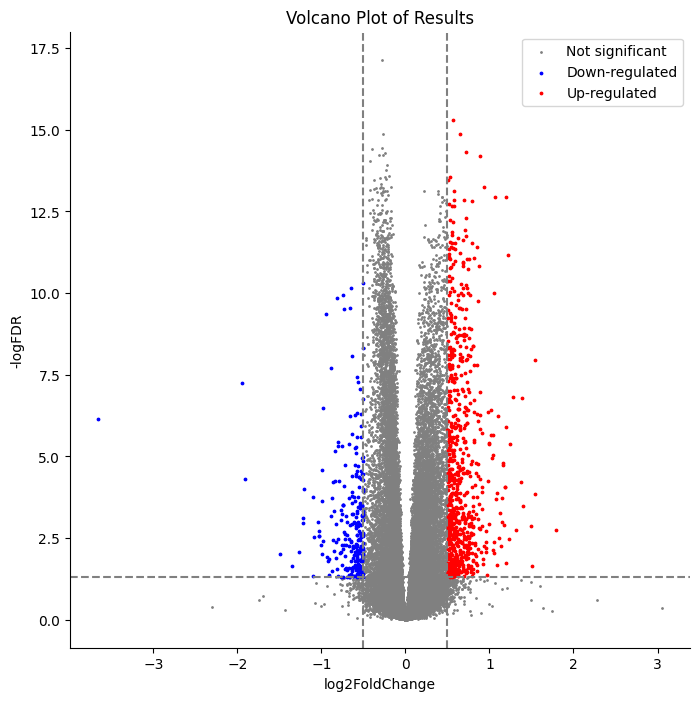

In [43]:
# Hemtools volcano plot

plt.figure(figsize=(8,8))
plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant", color = 'gray')

# highlight down- or up- regulated genes
down = res[(res['log2FoldChange']<=-0.5)&(res['padj']<=0.05)]
up = res[(res['log2FoldChange']>=0.5)&(res['padj']<=0.05)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")
plt.axvline(-0.5,color="grey",linestyle="--")
plt.axvline(0.5,color="grey",linestyle="--")
plt.axhline(1.3,color="grey",linestyle="--")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('Volcano Plot of Results')
plt.show()

## Additonal analysis - Gene Set Enrichment Analysis

Over-representation analysis is a computational method used to identify whether a set of genes, such as differentially expressed genes (DEGs), is over-represented in predefined gene sets or pathways. GSEApy is a Python package that provides tools for Gene Set Enrichment Analysis (GSEA), including enrichment analysis using the Enrichr database.

The goal is to explore and identify enriched biological processes, molecular functions, or cellular components associated with the list of DEGs.

[GSEAPY Docs](https://gseapy.readthedocs.io/en/latest/gseapy_example.html)

In [110]:
DEGs = sigs['gene_symbol'].tolist()

enr2 = gp.enrichr(gene_list=DEGs ,
 gene_sets=['GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'GO_Cellular_Component_2021'],
 organism='Human',
 outdir=None,
 cutoff=0.05
 )

enr2.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of calcium ion transmembra...,5/27,0.010676,0.999996,0,0,4.258220,19.331287,CXCL10;CALCR;CD19;GPER1;F2
1,GO_Biological_Process_2021,negative regulation of humoral immune response...,3/10,0.012020,0.999996,0,0,8.020287,35.459049,CR2;CR1L;FOXJ1
2,GO_Biological_Process_2021,regulation of B cell activation (GO:0050864),5/28,0.012465,0.999996,0,0,4.072865,17.858874,IGLL1;CD19;MZB1;TLR9;FOXJ1
3,GO_Biological_Process_2021,regulation of lymphocyte differentiation (GO:0...,4/20,0.016768,0.999996,0,0,4.680898,19.136808,CD2;TBX21;TLR9;CCR2
4,GO_Biological_Process_2021,amacrine cell differentiation (GO:0035881),2/5,0.023309,0.999996,0,0,12.466338,46.859930,NEUROD4;FOXN4


The adjusted p-values suggest there are no significantly enriched terms at the specified cutoff value (0.05) in your enrichment analysis results. This means none of the gene sets or pathways reached statistical significance. This does not necessarily mean the analysis is unsuccessful; it could reflect the characteristics of the dataset.

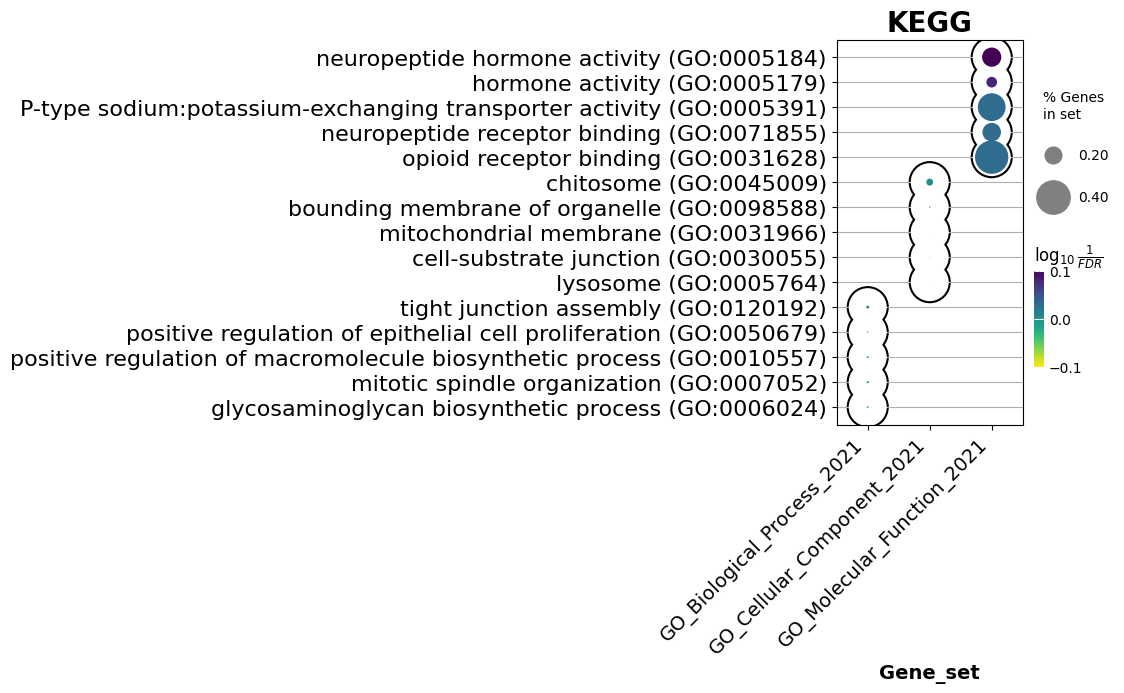

In [111]:
from gseapy.plot import barplot, dotplot
dotplot(enr2.results,
              column="Adjusted P-value",
              x='Gene_set',
              size=10,
              top_term=5,
              figsize=(3, 5),
              title="KEGG",
              xticklabels_rot=45,
              show_ring=True,
              marker='o',
              cutoff=1
             )
plt.show()

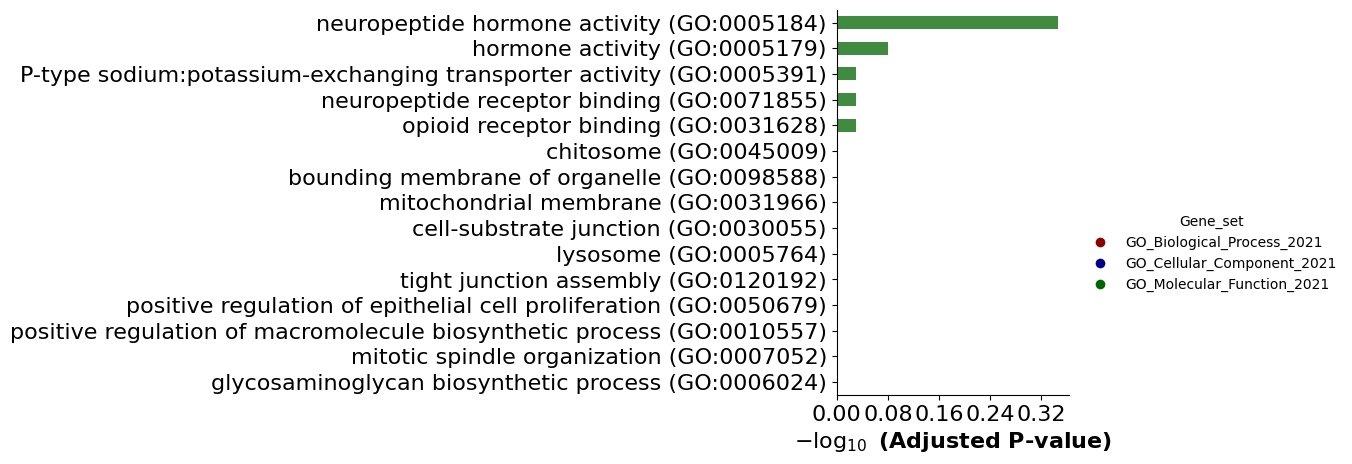

In [114]:
barplot(enr2.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              cutoff=1,
              color = ['darkred', 'darkblue', 'darkgreen']
             )
plt.show()

It appears that most information about these genes is associated with different molecular functions. Extending this analysis pipeline is a consideration for future work.

The primary goal is to move foward with implementing the top expressed genes as features in classification models.